# Task:  Build a Transfer Learning model to detect face masks on humans.

In [1]:
import ssl

import keras
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-06-06 10:57:05.360717: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# pip show keras
# # Name: keras
# # Version: 3.3.3

# Task A

## 1. Load the Image Training and Test Datasets from the train and test folder respectively. Each image is of shape 128 x 128 x 3

In [4]:
# train_data_generator = keras.preprocessing.image.ImageDataGenerator(
train_data_generator = ImageDataGenerator(
    horizontal_flip = True, vertical_flip = True, zoom_range = 0.1,
    shear_range = 0.1, width_shift_range = 0.2, height_shift_range = 0.2, rotation_range = 90
)

# test_data_generator = keras.preprocessing.image.ImageDataGenerator()
test_data_generator = ImageDataGenerator()

## 2. Load training dataset using Keras ImageDataGenerator with validation_split=0.2  

In [5]:
train_data = train_data_generator.flow_from_directory("./face_mask_detection_dataset/train",
                                                      target_size=(128,128), batch_size=1, shuffle=True)

Found 8082 images belonging to 3 classes.


## 3. Load test dataset using Keras ImageDataGenerator 

In [6]:
test_data = test_data_generator.flow_from_directory("./face_mask_detection_dataset/test",
                                                    target_size=(128,128), batch_size=1, shuffle=True)

Found 900 images belonging to 3 classes.


## Clean up the folder from unwanted items

In [ ]:

# import os

# # path to directory to save train data
# train_dir = './face_mask_detection_dataset/train'

# # list of folders
# folders1 = os.listdir(train_dir)
# folders1

# # Need to get rid of the first folder from this list.  Doesn't belong here.
# item_to_remove = '.ipynb_checkpoints'
# os.rmdir('./face_mask_detection_dataset/train/.ipynb_checkpoints')
# filtered_folders = [folder for folder in folders1 if folder != item_to_remove]
# filtered_folders

In [7]:
# Create extra function to transform data format and speed up learning process
def get_array_from_datagen(data):
    x=[]
    y=[]
    data.reset()
    for i in range(data.__len__()):
        # a, b = data.next()
        a, b = data.__next__()
        x.append(a)
        y.append(b)
    x = np.array(x, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    print(x.shape)
    print(y.shape)
    return x, y

In [8]:
X_train, y_train = get_array_from_datagen(train_data)
X_test, y_test = get_array_from_datagen(test_data)

(8082, 1, 128, 128, 3)
(8082, 1, 3)
(900, 1, 128, 128, 3)
(900, 1, 3)


In [9]:
X_train = X_train.reshape(-1, 128, 128, 3)
X_test = X_test.reshape(-1, 128, 128, 3)
y_train = y_train.reshape(-1, 3)
y_test = y_test.reshape(-1, 3)

In [10]:
# pip show numpy
# # Name: numpy
# # Version: 1.26.4

## 4. Build a Transfer Learning network using Keras with the following layers

### 4.1. Load EfficientNetB0 as first layers using Keras API.

### 4.2. GLobalAveragePooling2D layer

### 4.3. Dropout(0.2)

### 4.4. Dense layer with 3 neurons and activation softmax

In [11]:
ssl._create_default_https_context = ssl._create_unverified_context

In [12]:
base_model = keras.applications.EfficientNetB0(include_top=False)

In [13]:
efficient_net_model = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(3, activation='softmax')
])

In [14]:
efficient_net_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ ?                      │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 4,007,548 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

## 5. Compile the model with adam optimizer, categorical_crossentropy loss and with metrics accuracy.

In [15]:
efficient_net_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## 6. Train the model for 25 epochs with callbacks Reduce Learning Rate on Plateau and early stopping while monitoring validation loss

In [16]:
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    verbose=0,
    min_lr=0.00001
)

In [17]:
early_stopping = keras.callbacks.EarlyStopping(patience=5, verbose=1)

In [19]:
history = efficient_net_model.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs=3, #6 will take about 25 min.
    callbacks=[learning_rate_reduction, early_stopping]
)

Epoch 1/3
253/253 ━━━━━━━━━━━━━━━━━━━━ 555s 2s/step - accuracy: 0.9269 - loss: 0.2111 - val_accuracy: 0.9844 - val_loss: 0.0507 - learning_rate: 0.0010
Epoch 2/3
253/253 ━━━━━━━━━━━━━━━━━━━━ 580s 2s/step - accuracy: 0.9782 - loss: 0.0677 - val_accuracy: 0.9889 - val_loss: 0.0524 - learning_rate: 0.0010
Epoch 3/3
253/253 ━━━━━━━━━━━━━━━━━━━━ 564s 2s/step - accuracy: 0.9892 - loss: 0.0369 - val_accuracy: 0.9811 - val_loss: 0.0677 - learning_rate: 0.0010


## 7. Plot training and validation accuracy and loss against epochs

In [20]:
def plot_history(history):
    # visualize history of accuracy during training
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # visualize history of loss during training
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

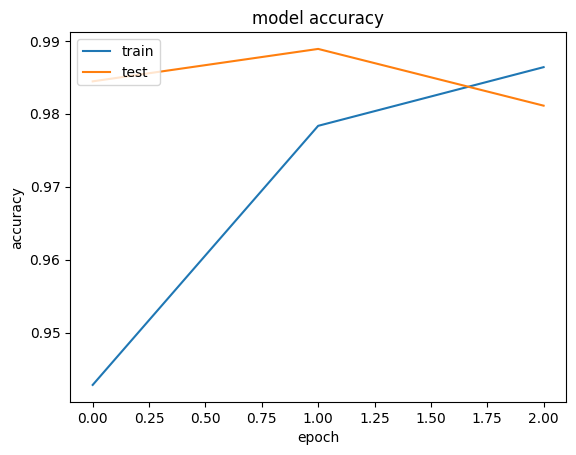

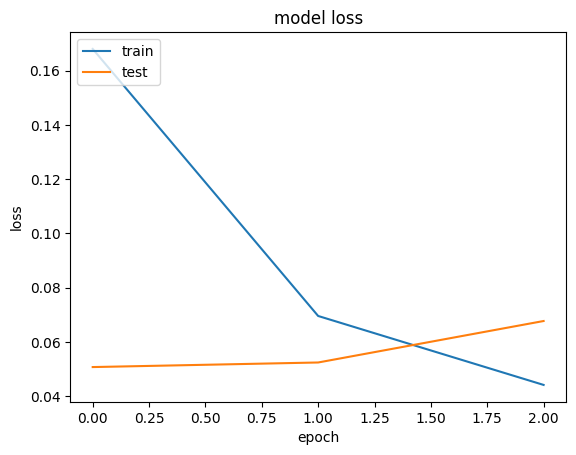

In [21]:
plot_history(history)

# Task B

## 1. Load the Image Training and Test Datasets from the train and test folder respectively. Each image is of shape 128 x 128 x 3

## 2. Load training dataset using Keras ImageDataGenerator with validation_split=0.2

## 3. Load test dataset using Keras ImageDataGenerator

In [ ]:
# This code was done above

## 4. Build a Transfer Learning network using Keras with the following layers

### 4.1. Load ResNet50 as first layers using Keras API.

### 4.2. GLobalAveragePooling2D layer

### 4.3. Dropout(0.5)

### 4.4. Dense layer with 3 neurons and activation softmax

In [ ]:
base_model_resnet = keras.applications.ResNet50(include_top=False)

resnet_model = keras.Sequential([
    base_model_resnet,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(3, activation='softmax')
])

## 5. Compile the model with adam optimizer, categorical_crossentropy loss and with metrics accuracy.

In [ ]:
resnet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## 6. Train the model for 25 epochs with callbacks Reduce Learning Rate on Plateau and early stopping while monitoring validation loss

In [ ]:
history = resnet_model.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs=3, #6 epoch takes about 45 min
    callbacks=[learning_rate_reduction, early_stopping]
)

## 7. Plot training and validation accuracy and loss against epochs

# Task C

## 1. Compare EfficientNetB0 and ResNet50 model performance and find the best model

In [ ]:
avg_loss, avg_accuracy = efficient_net_model.evaluate(X_test,y_test,batch_size=10)
print("Avg. Loss: ",avg_loss)
print("Avg. Accuracy: ",avg_accuracy)

In [ ]:
avg_loss, avg_accuracy = resnet_model.evaluate(X_test,y_test,batch_size=10)
print("Avg. Loss: ",avg_loss)
print("Avg. Accuracy: ",avg_accuracy)

In [ ]:
from sklearn.metrics import classification_report

report_efficient_net = classification_report(y_test.argmax(axis=1), efficient_net_model.predict(X_test).argmax(axis=1))

report_res_net = classification_report(y_test.argmax(axis=1), resnet_model.predict(X_test).argmax(axis=1))

In [ ]:
print("-- Efficient Model --")
print(report_efficient_net)

print("-- ResNet Model --")
print(report_res_net)

## 2. Using the best model predict on the test dataset and plot 10 images from the test set along with its True Label and Predicted Label.